Nonostante la pixel art generata con CycleGAN dia un risultato visivamente simila ad una pixel-art, c'è bisogno comunque di un post-processing che standardizzi la grandezza dei pixel.
La mia idea è quella di creare un canvas di dimensione fissa con una specifica dimensione di pixel e colorare ognuno di questi con il colore della palette che più si avvicina ad un colore random all'interno di esso.

In [1]:
!git clone https://github.com/felichan98/AISchools
import sys
sys.path.insert(0,'/content/AISchools')

Cloning into 'AISchools'...
remote: Enumerating objects: 19295, done.
remote: Counting objects: 100% (2511/2511), done.
remote: Compressing objects: 100% (2468/2468), done.
remote: Total 19295 (delta 45), reused 2503 (delta 40), pack-reused 16784
Receiving objects: 100% (19295/19295), 2.62 GiB | 36.69 MiB/s, done.
Resolving deltas: 100% (189/189), done.
Checking out files: 100% (2594/2594), done.


In [2]:
# Install OpenCV and Requirements
!pip uninstall imgaug -y
!pip install imgaug==0.2.5
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

import numpy as np

from matplotlib import pyplot as plt

import cv2
print('OpenCV version: ' + cv2.__version__)

Found existing installation: imgaug 0.2.9
Uninstalling imgaug-0.2.9:
  Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 562 kB 9.5 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-py3-none-any.whl size=561438 sha256=84d51476eecb75c9c89879c2a02f79b40cf038de2bca2c83321fa9844b1bfa8b
  Stored in directory: /root/.cache/pip/wheels/60/dd/38/d1dc2cad2b6a66dc0249261004990bccb0f27985c74ba26e49
Successfully built imgaug
     |████████████████████████████████| 60.5 MB 1.3 MB/s 
OpenCV version: 4.5.5


##Downsampling

Generazione di un'immagine di rumore.

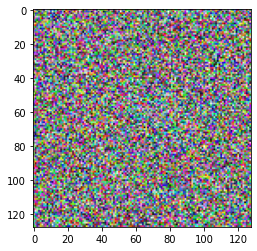

In [3]:
test_img = np.random.randint(0, 255, [128,128, 3], dtype='uint8')

plt.imshow(test_img)

Funzione che data un'immagine genera un'immagine della stessa dimensione dell'immagine di partenza riempita con un unico colore che è la media dei colori presenti inizialmente.

La definisco solo per questioni di semplicità, ma potrebbe essere usata qualsiasi altra funzione in seguito. (infatti farlo con la media dà un risultato di downsampling molto banale)

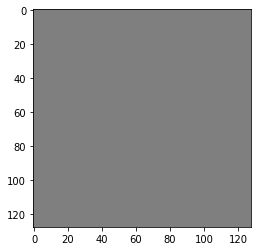

In [4]:
#Media colore

def color_avg(img):
  img_reshape = img.reshape(img.shape[0]*img.shape[1], 3)
  avg_ch1 = img_reshape[:,0].sum()//img_reshape.shape[0]
  avg_ch1 = avg_ch1.astype('uint8')

  avg_ch2 = img_reshape[:,1].sum()//img_reshape.shape[0]
  avg_ch2 = avg_ch2.astype('uint8')

  avg_ch3 = img_reshape[:,2].sum()//img_reshape.shape[0]
  avg_ch3 = avg_ch3.astype('uint8')

  res = np.full(img.shape, [avg_ch1, avg_ch2, avg_ch3], dtype = np.uint8)
  return res
  

plt.imshow(color_avg(test_img))

Adesso suddivido l'immagine iniziale in tante sotto immagini e ad ognuna di queste applico la media e poi ricompongo da queste sottomatrici una foto down-sampled dell'immagine di partenza.

Carico una foto più esplicativa del rumore.

In [5]:
from google_drive_downloader import GoogleDriveDownloader as gdd

# IMMAGINI DI PROVA

gdd.download_file_from_google_drive(file_id='1ieQPcNvHnz3vNEHkQIMIF55OO2crZ3X6',
                                    dest_path='./data/cat.png',
                                    unzip=False)

im_path1 = './data/cat.png'

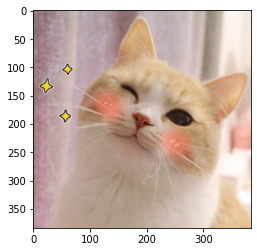

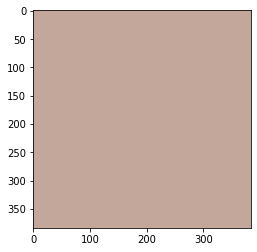

In [6]:
img_cat = cv2.imread(im_path1, cv2.IMREAD_COLOR)
img_cat = cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB)

plt.imshow(img_cat)
plt.show()

plt.imshow(color_avg(img_cat))
plt.show()


Voglio che il rapporto tra immagine e dimensione pixel sia sempre di samlpe_size (in questo caso 32). 
Quindi la dimensione dei micro-blocchi (lo step di campionamento) sarà height/32 x width/32.

13 13


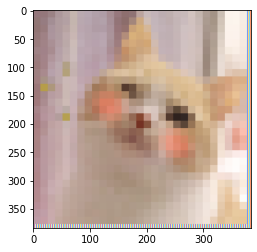

In [7]:
sample_size = 32

def pixxelate(img, sample_size):
  (h, w) = img.shape[:2]

  (stepW, stepH) = ((w // sample_size) + 1, (h // sample_size) +1)

  print(stepW, stepH)

  img_res = np.empty(img.shape, dtype = np.uint8)

  ## 1 - prendi una sottomatrice stepW * stepH * 3 dall'array di partenza
  ## 2 - calcola la media (o qualsiasi altra funzione) dei colori
  ## 3 - inserisci nelle posizioni corrispondenti dell'immagine risultato il colore calcolato

  for i in range(sample_size):
    for j in range(sample_size):
      if(i*stepH + stepH <= img.shape[0] and j* stepW + stepW <= img.shape[1]):
        
        img_tmp = img[i*stepH :i*stepH + stepH, j* stepW :j* stepW + stepW]
        avg = color_avg(img_tmp)

        img_res[i*stepH :i*stepH + stepH, j* stepW :j* stepW + stepW] = avg

  return img_res


plt.imshow(pixxelate(img_cat, sample_size))
plt.show()

##Palette choose

Prossimo step: non utilizzare la media ma associare ad ogni campione il colore della palette che più si avvicina alla media dei colori. In questo modo l'immagine sarà più nitida.

Utilizzo un array di colori (palette) e associo al pixel il colore della palette con distanza minore. La generazione della palette è spiegata in Palette_extraction.ipynb

Lo sviluppo delle seguenti funzioni è descritto in Color_shifting.ipynb

In [8]:
def color_distance(color1, color2):

  # Converto da uint a int perchè altrimenti con le differenze se viene un numero negativo sfora la codifica e va in overflow

  color1 = color1.astype(np.int16)
  color2 = color2.astype(np.int16)

  distance = np.abs(color1[0] - color2[0]) + np.abs(color1[1] - color2[1]) + np.abs(color1[2] - color2[2])
  return distance

def palette_choose(palette, pixel):

  #Per ogni pixel slista la palette di colori e restituisce il colore più vicino (Quello con minima distanza pixel-colore)

  distances = []

  for index, color in enumerate(palette):
    #print(color_distance(pixel, color))
    distances.append(color_distance(pixel, color))
    #print(index, color)

  (minvalue,minIndex) = min((v,i) for i,v in enumerate(distances))

  return palette[minIndex]

Modifico la funzione pixxelate aggiungendo questa feature

In [9]:
sample_size = 32

def pixxelate(img, sample_size, palette):
  (h, w) = img.shape[:2]

  (stepW, stepH) = ((w // sample_size) + 1, (h // sample_size) +1)

  print (stepW, stepH)

  img_res = np.empty(img.shape, dtype = np.uint8)

  ## 1 - prendi una sottomatrice stepW * stepH * 3 dall'array di partenza
  ## 2 - calcola la media (o qualsiasi altra funzione) dei colori
  ## 3 - inserisci nelle posizioni corrispondenti dell'immagine risultato il colore calcolato

  for i in range(sample_size):
    for j in range(sample_size):
      if(i*stepH + stepH <= img.shape[0] and j* stepW + stepW <= img.shape[1]):
        img_tmp = img[i*stepH :i*stepH + stepH, j* stepW :j* stepW + stepW]

        #In questo caso per avere un risultato piu nitido non utilizzo color_avg ma il primo colore in img_tmp
        avg = img_tmp

        palette_color = palette_choose(palette, avg[0][0])

        avg = np.full(avg.shape, [palette_color[0], palette_color[1], palette_color[2]], dtype = np.uint8)

        img_res[i*stepH :i*stepH + stepH, j* stepW :j* stepW + stepW] = avg

  return img_res


#Risultato

In [10]:
palette = []
palette.append(np.array([8,16,25]))
palette.append(np.array([ 24,8,25]))
palette.append(np.array([ 24,9,25]))
palette.append(np.array([ 86,116,150]))
palette.append(np.array([ 90,32,92]))
palette.append(np.array([ 90,53,92]))
palette.append(np.array([ 91,53,92]))
palette.append(np.array([103,86,150]))
palette.append(np.array([150,69,53]))
palette.append(np.array([211,192,188]))

5 5


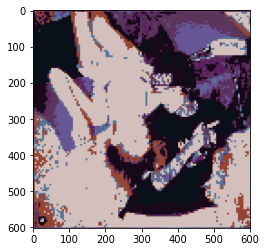

In [11]:
im_path2 = '/content/AISchools/Pictures/venz.JPG'
img_2 = cv2.imread(im_path2, cv2.IMREAD_COLOR)
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

test = pixxelate(img_2, 128, palette)

plt.imshow(test)